In [2]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy import sparse
import os.path
from scipy.interpolate import splrep, splev

In [3]:
def ALS_solve(M, Ω, r, mu, epsilon=1e-3, max_iterations=100, debug = False):
    """
    Solve probabilistic matrix factorization using alternating least squares.

    Since loss function is non-convex, each attempt at ALS starts from a
    random initialization and returns a local optimum.

    [ Salakhutdinov and Mnih 2008 ]
    [ Hu, Koren, and Volinksy 2009 ]

    Parameters:
    -----------
    M : m x n array
        matrix to complete

    Ω : m x n array
        matrix with entries zero (if missing) or one (if present)

    r : integer
        how many factors to use

    mu : float
        hyper-parameter penalizing norm of factored U, V

    epsilon : float
        convergence condition on the difference between iterative results

    max_iterations: int
        hard limit on maximum number of iterations

    Returns:
    --------
    X: m x n array
        completed matrix
    """
    #logger = logging.getLogger(__name__)
    n1, n2 = M.shape

    U = np.random.randn(n1, r)
    V = np.random.randn(n2, r)

    prev_X = np.dot(U, V.T)

    def solve(M, U, Ω):
        V = np.zeros((M.shape[1], r))
        mu_I = mu * np.eye(U.shape[1])
        for j in range(M.shape[1]):
            X1 = Ω[:, j:j+1].copy() * U
            X2 = X1.T @ X1 + mu_I
            #V[j] = (np.linalg.pinv(X2) @ X1.T @ (M[:, j:j+1].copy())).T
            #print(M[:, j:j+1].shape)
            V[j] = np.linalg.solve(X2, X1.T @ (M[:, j:j+1].copy())).reshape(-1)
        return V

    for _ in range(max_iterations):

        U = solve(M.T, V, Ω.T)

        V = solve(M, U, Ω)


        X = np.dot(U, V.T)

        mean_diff = np.linalg.norm(X - prev_X) / np.linalg.norm(X)
        #if _ % 1 == 0:
        #    logger.info("Iteration: %i; Mean diff: %.4f" % (_ + 1, mean_diff))
        if (debug):
            print("Iteration: %i; Mean diff: %.4f" % (_ + 1, mean_diff))
        
        if mean_diff < epsilon:
            break
        prev_X = X

    return X


In [4]:
def noise_to_signal(X, M, Ω):
    return np.sqrt(np.sum((Ω*X - Ω*M)**2) / np.sum((Ω*M)**2))

In [5]:
def abs_mean(X, M, Ω):
    return np.sum(np.abs((X-M)*Ω)) / np.sum(Ω)

In [6]:
## least-squares solved via single SVD
def SVD(M,r): #input matrix M, approximating with rank r
    u,s,vh = np.linalg.svd(M, full_matrices=False) #s is diag
    X = u[:,:r].dot(np.diag(np.sqrt(s[:r])))
    Y = vh[:r,:].T.dot(np.diag(np.sqrt(s[:r])))
    return X.dot(Y.T), X, Y## least-squares solved via single SVD

In [7]:
def low_rank_matrix_generation(n1, n2, r, gamma_shape, gamma_scale, mean_M):
    '''
        generate a low-rank matrix M0
        low rank components are entry-wise Gamma distribution
        mean_M: the mean value of M0
    '''
    U = np.random.gamma(shape = gamma_shape, scale = gamma_scale, size = (n1, r))
    V = np.random.gamma(shape = gamma_shape, scale = gamma_scale, size = (n2, r))
    M0 = U.dot(V.T)
    M0 = M0 / np.mean(M0) * mean_M
    return M0

### Compute Sigma 

In [8]:
def compute_Sigma_Poisson(M0, r, p_observe):
    '''
        Compute the standard deviation of least-square estimator for Poisson noise

        The formula is specified in the paper 
    '''
    u,s,vh = np.linalg.svd(M0, full_matrices=False)
    U = u[:, :r]
    V = vh[:r, :].T

    sigmaS = ((U.dot(U.T))**2).dot(M0) + M0.dot((V.dot(V.T))**2)
    sigmaS /= p_observe
    sigmaS = np.sqrt(sigmaS)

    return sigmaS

def compute_Sigma_Bernoulli(M0, r, p_observe):
    u,s,vh = np.linalg.svd(M0, full_matrices=False)
    U = u[:, :r]
    V = vh[:r, :].T

    sigmaS = ((U.dot(U.T))**2).dot(M0*(1-M0)) + (M0*(1-M0)).dot((V.dot(V.T))**2)
    sigmaS /= p_observe
    sigmaS = np.sqrt(sigmaS)

    return sigmaS

def compute_Sigma_adpative(Mhat, E, r, p_observe):
    u,s,vh = np.linalg.svd(Mhat, full_matrices=False)
    U = u[:, :r]
    V = vh[:r, :].T

    sigmaS = ((U.dot(U.T))**2).dot(E**2) + (E**2).dot((V.dot(V.T))**2)
    sigmaS /= (p_observe**2)
    sigmaS = np.sqrt(sigmaS)

    return sigmaS


## Simulation: Single Entry Distribution Plot

In [24]:
np.random.seed(1)

n = 300
r = 2
M0 = low_rank_matrix_generation(n1=n, n2=n, r=r, gamma_shape=2, gamma_scale=1, mean_M=20)

index_i = 0
index_j = 0

u,s,vh = np.linalg.svd(M0, full_matrices=False)
U = u[:, :r]
V = vh[:r, :].T
#print(U, V)

num_experiment = 1000 #set to >= 10000 for the plot in the paper 
p_observe = 0.6
exp_list = []
for i in range(num_experiment): 
    X = np.random.poisson(M0)
    #X = np.random.binomial(1, np.minimum(M0, 1))
    Ω = np.random.rand(n, n) <= p_observe
    Mhat = ALS_solve(X, Ω, r, 0)
    while (np.linalg.norm(Mhat-M0) / np.linalg.norm(M0) > 1):
        Mhat = ALS_solve(X, Ω, r, 0)
    exp_list.append((Mhat - M0)[index_i, index_j]) 
    #print(np.mean(np.abs(Mhat - M0)))


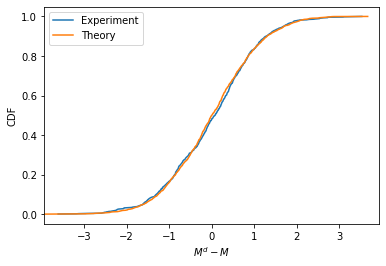

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


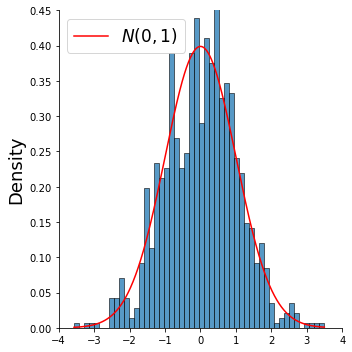

In [26]:
sigmaS = compute_Sigma_Poisson(M0, r, p_observe)

thm_list = np.zeros(2000)
for i in range(2000):
    thm_list[i] = np.random.normal(loc=0, scale=sigmaS[index_i, index_j])

from scipy.stats import norm

def CDF(points):
    points = np.sort(points)
    Y = np.arange(1, len(points)+1, 1) / len(points)
    return points, Y

def pdf(samples):
    samples = np.array(samples) / sigmaS[index_i, index_j]
    #hist, bined = np.histogram(samples, bins = 300, density=True)
    #plt.plot((bined[:-1]/2+bined[1:]/2), hist)
    pos_guassian = np.linspace(min(samples), max(samples), 1000)
    pdf_guassian = norm.pdf(pos_guassian, loc=0, scale=1)
    #plt.plot(pos_guassian, pdf_guassian)
    #plt.show()

    g = sns.displot(data=samples, kind='hist', stat='density', bins=50)
    g.set(xlim=(-4, 4))
    g.set(ylim=(0.0, 0.45))
    plt.plot(pos_guassian, pdf_guassian, label=r'$N(0, 1)$', color='r')
    plt.legend(fontsize = 17)
    plt.ylabel('Density', fontsize = 18)
    plt.tight_layout()
    plt.savefig('distribution.eps')
    plt.show()

X1, Y1 = CDF(exp_list)
X2, Y2 = CDF(thm_list)
plt.plot(X1, Y1, X2, Y2)
plt.xlim([X2.min(), -X2.min()])
plt.legend(['Experiment', 'Theory'])
plt.xlabel(r'$M^{d} - M$')
plt.ylabel('CDF')
plt.show()

pdf(exp_list)

## Simulation: Coverage Rate 95% Verification

In [27]:
def compute_coverage_rate_with_CI(M0, Mhat, sigmaS, CI, Ω=None):
    if (Ω is None):
        Ω = np.ones_like(M0)
    delta = (1-CI)/2
    mul = norm.ppf(CI+delta)
    return np.sum((np.abs(M0-Mhat) <= sigmaS * mul)*Ω) / np.sum(Ω)

In [31]:
#np.random.seed(1)

n = 500

for r in [3, 6]:
    for p in [0.3, 0.6]:
        for mean_M in [5, 20]:
            num_experiment = 10 # set to >= 100 for the results in the paper
            results = []
            for i in range(num_experiment): 
                M0 = low_rank_matrix_generation(n1=n, n2=n, r=r, gamma_shape=2, gamma_scale=1, mean_M=mean_M)
                p_observe = p
                sigmaS = compute_Sigma_Poisson(M0, r, p_observe)
                X = np.random.poisson(M0)
                Ω = np.random.rand(n, n) <= p_observe
                Mhat = ALS_solve(X, Ω, r, 0)
                while (np.linalg.norm(Mhat-M0) / np.linalg.norm(M0) > 1):
                    Mhat = ALS_solve(X, Ω, r, 0)

                results.append(compute_coverage_rate_with_CI(M0, Mhat, sigmaS, CI=0.95))

            print(np.mean(results), np.std(results))
    

0.9420104 0.002444868716311778
0.9446532000000001 0.002204836175320076
0.9470328 0.003080624248427583
0.9500352 0.0025127691816002593
0.906968 0.0053965580141419655
0.9340728 0.003306008977604256
0.9340784 0.0032781390818572664
0.9445612000000001 0.0018714974111657178


## Sales data: Maximizing Coverage Rate with Limited Budgets

In [46]:
import pickle
sale_matrix = pickle.load(open('drug_sale.p', 'rb'))
sale_matrix = sale_matrix.fillna(0).to_numpy()
print(sale_matrix.shape)
remaining_cols = np.sum(sale_matrix==0, axis = 0) < 200 #filtering cols
remaining_rows = np.sum(sale_matrix==0, axis = 1) < 200 #filtering rows

sale_matrix = sale_matrix[:, remaining_cols]
sale_matrix = sale_matrix[remaining_rows, :]
O = sale_matrix
O = np.maximum(O, 0)

(1115, 942)


In [51]:
def Inverse_Gaussian(t, S):
    A = -2 * (t + np.log(S * np.sqrt(2*np.pi))) * (S**2)
    A = np.maximum(A, 0)
    return np.sqrt(A)
    
def compute_coverage_rate_with_budget(M0, Mhat, sigmaS, budget, eps = 1e-6, Omega=None):
    if (Omega is None):
        Omega = np.ones_like(M0)
    l_bound = 0
    sigma = np.min(sigmaS)
    r_bound = 1 / sigma / np.sqrt(2*np.pi)
    while (r_bound - l_bound > eps):
        mid = (r_bound + l_bound) / 2
        cost = 0
        A = Inverse_Gaussian(np.log(mid), sigmaS) 
        cost = 2 * np.sum(A)
        if (cost > budget):
            l_bound = mid
        else:
            r_bound = mid

    return np.sum((np.abs(M0-Mhat) <= A)*Omega) / np.sum(Omega)

def budget_coverage_rate(M0, Mhat, sigmaS, Omega=None, s = None):
    if (Omega is None):
        Omega = np.ones_like(M0)
    cost = []
    coverage = []
    if (s is None):
        s =  np.arange(-30, np.log(1 / np.min(sigmaS) / np.sqrt(2*np.pi))+0.1, 0.1)
    for t in s:
        A = Inverse_Gaussian(t, sigmaS)
        cost.append(np.sum(A*Omega) * 2)
        coverage.append(np.sum((np.abs(M0-Mhat) <= A)*Omega) / np.sum(Omega))
    return s, cost, coverage 

In [55]:
r = 4
n1 = O.shape[0]
n2 = O.shape[1]

num_experiment = 1
p_observe = 0.95
exp_list = []
for i in range(num_experiment):
    X = O
    Ω = (np.random.rand(n1, n2) <= p_observe)
    
    M0 = X
    u,s,vh = np.linalg.svd(M0, full_matrices=False)
    U = u[:, :r]
    V = vh[:r, :].T

    X_r = (U*s[:r]).dot(V.T)

    Mhat = ALS_solve(X, Ω, r, 0)
    #print(np.sqrt(np.sum(M0)) / np.linalg.norm(M0))
    #print(np.linalg.norm((Mhat-X)*(1-Ω)) / np.linalg.norm(X*(1-Ω)))
    while (np.linalg.norm(Mhat-M0) / np.linalg.norm(M0) > 1):
        Mhat = ALS_solve(X, Ω, r, 0)
    #Mhat = np.maximum(Mhat, 0)

    sigmaS = compute_Sigma_Poisson(Mhat, r, p_observe)
    
    u,s,vh = np.linalg.svd(Mhat, full_matrices=False)
    Uhat = u[:, :r]
    Vhat = vh[:r, :].T

    gaussianS = np.zeros_like(M0)
    gaussianS = np.ones((n1,1)).dot(np.sum(Vhat**2, axis=1).reshape(1, -1)) + np.sum(Uhat**2, axis=1).reshape(-1, 1).dot(np.ones((1, n2)))
    gaussianS /= p_observe
    gaussianS = np.sqrt(gaussianS)
    sigma = np.sqrt(np.sum(((Mhat-X)**2)*Ω)/np.sum(Ω))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


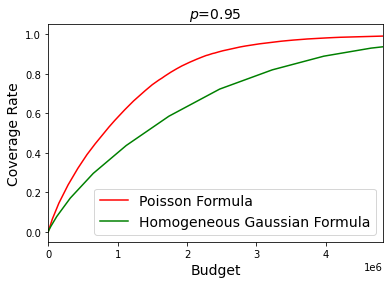

In [56]:
_, cost_A, coverage_A = budget_coverage_rate(X_r, Mhat, sigmaS, 1-Ω, np.arange(-35, np.log(1 / np.min(sigmaS) / np.sqrt(2*np.pi))+0.1, 0.2))
_, cost_B, coverage_B = budget_coverage_rate(X_r, Mhat, gaussianS*sigma, 1-Ω, np.arange(-20, np.log(1 / np.min(sigmaS) / np.sqrt(2*np.pi))+0.1, 0.1))
plt.plot(cost_A, coverage_A, color='r')
plt.plot(cost_B, coverage_B, color='g')
plt.xlim([0, cost_A[0]])
plt.legend(['Poisson Formula', 'Homogeneous Gaussian Formula'], fontsize=14)
plt.xlabel('Budget', fontsize=14)
plt.ylabel('Coverage Rate', fontsize=14)
plt.title(r'$p$={}'.format(p_observe), fontsize=14)
plt.savefig('real-data-coverage-rate-comparison.eps')
plt.show()